In [1]:
import pandas as pd
import numpy as np
import os
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from env import get_db_url
import acquire
import prepare

alpha = .05

## Acquire 

In [2]:
def get_telco_data():

    '''This function pulls telco data from the Codeup database and saves
    the file as a .csv'''
    filename = 'telco_data.csv'

    if os.path.isfile(filename):
        return pd.read_csv(filename)
    else:
       sql_query = '''SELECT * from customers
                JOIN contract_types using (contract_type_id)
                JOIN internet_service_types using (internet_service_type_id)
                JOIN payment_types using (payment_type_id)'''
       
    
    df = pd.read_sql(sql_query, get_db_url('telco_churn'))

    df.to_csv(filename)

    return df

In [3]:
df = acquire.get_telco_data()
df.head()

,Unnamed: 0,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,1,2,1,1,0003-MKNFE,Male,0,No,No,9,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,2,1,2,1,0004-TLHLJ,Male,0,No,No,4,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


## Prepare 

In [4]:
# replace empty cells with nulls
df = df.replace(' ', np.nan)

In [5]:
# check df for nulls
df.isna().sum()

Unnamed: 0                   0
payment_type_id              0
internet_service_type_id     0
contract_type_id             0
customer_id                  0
gender                       0
senior_citizen               0
partner                      0
dependents                   0
tenure                       0
phone_service                0
multiple_lines               0
online_security              0
online_backup                0
device_protection            0
tech_support                 0
streaming_tv                 0
streaming_movies             0
paperless_billing            0
monthly_charges              0
total_charges               11
churn                        0
contract_type                0
internet_service_type        0
payment_type                 0
dtype: int64

In [6]:
# drop 11 nulls from total_charges
df.dropna(inplace=True)

In [7]:
# check df for nulls
df.isna().sum()

Unnamed: 0                  0
payment_type_id             0
internet_service_type_id    0
contract_type_id            0
customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
paperless_billing           0
monthly_charges             0
total_charges               0
churn                       0
contract_type               0
internet_service_type       0
payment_type                0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                7032 non-null   int64  
 1   payment_type_id           7032 non-null   int64  
 2   internet_service_type_id  7032 non-null   int64  
 3   contract_type_id          7032 non-null   int64  
 4   customer_id               7032 non-null   object 
 5   gender                    7032 non-null   object 
 6   senior_citizen            7032 non-null   int64  
 7   partner                   7032 non-null   object 
 8   dependents                7032 non-null   object 
 9   tenure                    7032 non-null   int64  
 10  phone_service             7032 non-null   object 
 11  multiple_lines            7032 non-null   object 
 12  online_security           7032 non-null   object 
 13  online_backup             7032 non-null   object 
 14  device_p

In [9]:
# change total_charges to float
df['total_charges'] = pd.to_numeric(df['total_charges'])

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,7032.0,3522.306314,2034.073173,0.00,1759.7500,3524.500,5283.2500,7042.00
payment_type_id,7032.0,2.315557,1.149523,1.00,1.0000,2.000,3.0000,4.00
internet_service_type_id,7032.0,1.872582,0.737271,1.00,1.0000,2.000,2.0000,3.00
contract_type_id,7032.0,1.688567,0.832934,1.00,1.0000,1.000,2.0000,3.00
senior_citizen,7032.0,0.162400,0.368844,0.00,0.0000,0.000,0.0000,1.00
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
monthly_charges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
total_charges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80


In [11]:
# determine columns to drop
# Unnamed: 0 (note needed)	payment_type_id	internet_service_type_id	contract_type_id (already in additional columns)
df = df.drop(columns=['Unnamed: 0', 'payment_type_id', 'internet_service_type_id', 'contract_type_id'])

In [12]:
# convert categorical columns to boolean
df['is_female'] = df['gender'].map({'Female': 1, 'Male': 0})
df['has_partner'] = df['partner'].map({'Yes': 1, 'No': 0})
df['has_dependents'] = df['dependents'].map({'Yes': 1, 'No': 0})
df['has_phone_service'] = df['phone_service'].map({'Yes': 1, 'No': 0})
df['has_paperless_billing'] = df['paperless_billing'].map({'Yes': 1, 'No': 0})
df['has_churned'] = df['churn'].map({'Yes': 1, 'No': 0})

df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,churn,contract_type,internet_service_type,payment_type,is_female,has_partner,has_dependents,has_phone_service,has_paperless_billing,has_churned
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,No,Yes,...,No,One year,DSL,Mailed check,1,1,1,1,1,0
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,No,No,...,No,Month-to-month,DSL,Mailed check,0,0,0,1,0,0
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,No,No,...,Yes,Month-to-month,Fiber optic,Electronic check,0,0,0,1,1,1
3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,No,Yes,...,Yes,Month-to-month,Fiber optic,Electronic check,0,1,0,1,1,1
4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,No,No,...,Yes,Month-to-month,Fiber optic,Mailed check,1,1,0,1,1,1


In [13]:
dummy_df = pd.get_dummies(df[['contract_type','internet_service_type', 'payment_type',\
                              'multiple_lines', 'online_security', 'online_backup',\
                              'tech_support', 'streaming_tv', 'streaming_movies']],dummy_na=False, drop_first=True)

In [14]:
df = pd.concat([df, dummy_df], axis=1)
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,online_security_No internet service,online_security_Yes,online_backup_No internet service,online_backup_Yes,tech_support_No internet service,tech_support_Yes,streaming_tv_No internet service,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,No,Yes,...,0,0,0,1,0,1,0,1,0,0
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,No,No,...,0,0,0,0,0,0,0,0,0,1
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,No,No,...,0,0,0,0,0,0,0,0,0,0
3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,No,Yes,...,0,0,0,1,0,0,0,1,0,1
4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,No,No,...,0,0,0,0,0,1,0,1,0,0


In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
senior_citizen,7032.0,0.162400,0.368844,0.00,0.0000,0.000,0.0000,1.00
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
monthly_charges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
total_charges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80
is_female,7032.0,0.495307,0.500014,0.00,0.0000,0.000,1.0000,1.00
has_partner,7032.0,0.482509,0.499729,0.00,0.0000,0.000,1.0000,1.00
has_dependents,7032.0,0.298493,0.457629,0.00,0.0000,0.000,1.0000,1.00
has_phone_service,7032.0,0.903299,0.295571,0.00,1.0000,1.000,1.0000,1.00
has_paperless_billing,7032.0,0.592719,0.491363,0.00,0.0000,1.000,1.0000,1.00
has_churned,7032.0,0.265785,0.441782,0.00,0.0000,0.000,1.0000,1.00


In [16]:
train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=123, 
                                        stratify=df.churn)
train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123, 
                                   stratify=train_validate.churn)


In [17]:
train.shape, validate.shape, test.shape

((3937, 46), (1688, 46), (1407, 46))

In [18]:
# confirm data was stratified
train.churn.value_counts(normalize=True), validate.churn.value_counts(normalize=True), test.churn.value_counts(normalize=True)

(No     0.734315
 Yes    0.265685
 Name: churn, dtype: float64,
 No     0.734005
 Yes    0.265995
 Name: churn, dtype: float64,
 No     0.734186
 Yes    0.265814
 Name: churn, dtype: float64)

In [19]:
def clean_telco_data(df):
    # replace empty cells with nulls
    df = df.replace(' ', np.nan)
    # drop 11 nulls from total_charges
    df.dropna(inplace=True)
    # change total_charges to float
    df['total_charges'] = pd.to_numeric(df['total_charges'])
    # drop unnecessary columns
    df = df.drop(columns=['Unnamed: 0', 'payment_type_id', 'internet_service_type_id', 'contract_type_id'])
    # convert categorical columns to boolean
    df['is_female'] = df['gender'].map({'Female': 1, 'Male': 0})
    df['has_partner'] = df['partner'].map({'Yes': 1, 'No': 0})
    df['has_dependents'] = df['dependents'].map({'Yes': 1, 'No': 0})
    df['has_phone_service'] = df['phone_service'].map({'Yes': 1, 'No': 0})
    df['has_paperless_billing'] = df['paperless_billing'].map({'Yes': 1, 'No': 0})
    df['has_churned'] = df['churn'].map({'Yes': 1, 'No': 0})
    df['has_multiple_lines'] = df['multiple_lines'].map({'Yes': 1, 'No': 0})
    df['has_online_security'] = df['online_security'].map({'Yes': 1, 'No': 0})
    df['has_online_backup'] = df['online_backup'].map({'Yes': 1, 'No': 0})
    df['has_tech_support'] = df['tech_support'].map({'Yes': 1, 'No': 0})
    df['has_streaming_tv'] = df['streaming_tv'].map({'Yes': 1, 'No': 0})
    df['has_streaming_movies'] = df['streaming_movies'].map({'Yes': 1, 'No': 0})
    # encode categorical columns 
    dummy_df = pd.get_dummies(df[['contract_type','internet_service_type', 'payment_type']],dummy_na=False, drop_first=True)
    #combine dataframes
    df = pd.concat([df, dummy_df], axis=1)
    
    return df
    


In [20]:
def prep_telco_data(df):
    df = clean_titanic_data(df)
    train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=123, 
                                        stratify=df.churn)
    train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123, 
                                   stratify=train_validate.churn)
    
    return train, validate, test
    

## Explore
    

In [21]:
train.churn.value_counts()

No     2891
Yes    1046
Name: churn, dtype: int64

<AxesSubplot:>

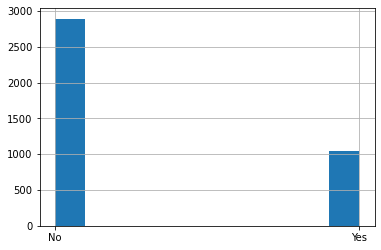

In [22]:
train.churn.hist()

<AxesSubplot:xlabel='gender', ylabel='has_churned'>

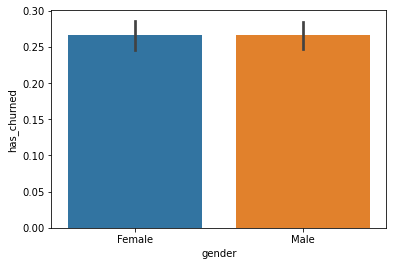

In [23]:
sns.barplot(data=train, x = 'gender', y = 'has_churned')

Gender does not appear to affect churn.

<AxesSubplot:xlabel='churn', ylabel='monthly_charges'>

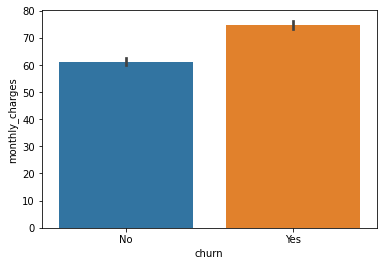

In [24]:
sns.barplot(data=train, y='monthly_charges', x='churn')

<AxesSubplot:xlabel='churn', ylabel='monthly_charges'>

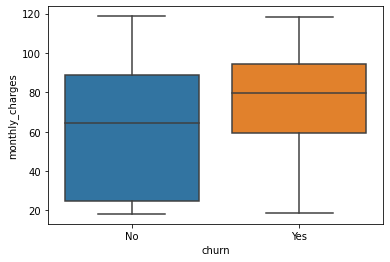

In [25]:
sns.boxplot(data=train,  y='monthly_charges', x='churn')

Those that churn have, on average, higher monthly bills.

<AxesSubplot:xlabel='contract_type', ylabel='count'>

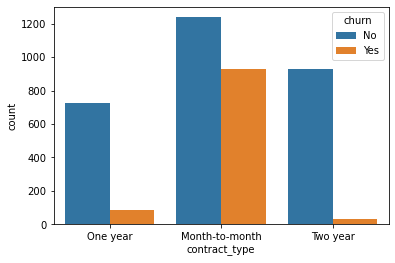

In [26]:
sns.countplot(data=train, x='contract_type', hue='churn')

Customers with month-to-month contracts are more likely to churn.

<AxesSubplot:xlabel='senior_citizen', ylabel='count'>

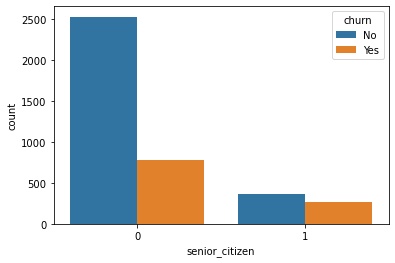

In [27]:
sns.countplot(data=train, x='senior_citizen', hue ='churn')

Senior citizens are more likely to churn.

<AxesSubplot:xlabel='dependents', ylabel='count'>

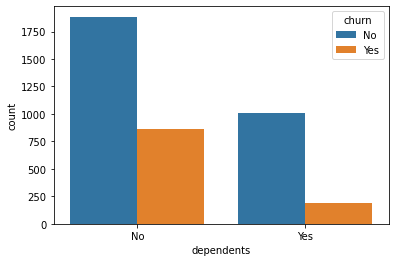

In [28]:
sns.countplot(data=train, x='dependents', hue ='churn')

Customers without dependents are more likely to churn.

<AxesSubplot:xlabel='partner', ylabel='count'>

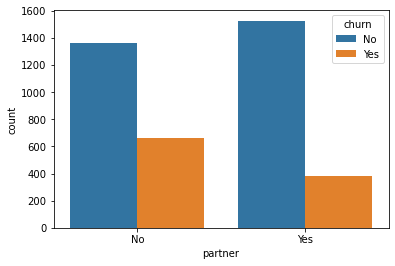

In [29]:
sns.countplot(data=train, x='partner', hue ='churn')

Customers without partners are more likely to churn.

<AxesSubplot:xlabel='churn', ylabel='count'>

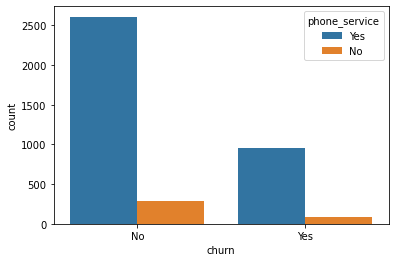

In [30]:
sns.countplot(data=train, x='churn', hue ='phone_service')

Phone service does not appear to be a predictor of churn.

<AxesSubplot:xlabel='churn', ylabel='count'>

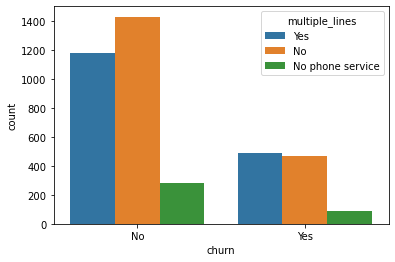

In [31]:
sns.countplot(data=train, x='churn', hue ='multiple_lines')

Having multiples lines does not appear to be a predictor of churn.

<AxesSubplot:xlabel='churn', ylabel='count'>

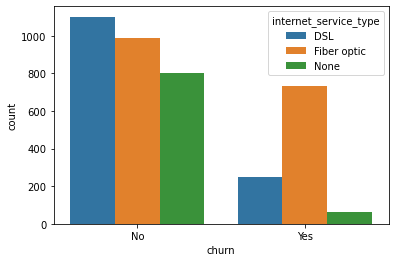

In [32]:
sns.countplot(data=train, x='churn', hue ='internet_service_type')

Those with Fiber optic internet are more likely to churn.

<AxesSubplot:xlabel='churn', ylabel='count'>

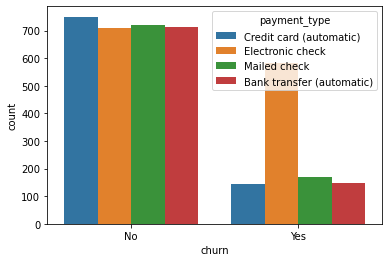

In [33]:
sns.countplot(data=train, x='churn', hue ='payment_type')

Customers that pay with electronic check are more likely to churn.

Text(0.5, 1.0, 'Customers without online security are more likely to churn')

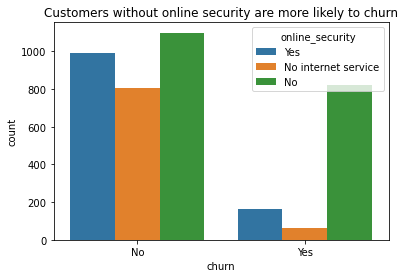

In [34]:
# explore add-on services
sns.countplot(data=train, x='churn', hue ='online_security')
plt.title('Customers without online security are more likely to churn')

Customers without online security are more likely to churn.

<AxesSubplot:xlabel='churn', ylabel='count'>

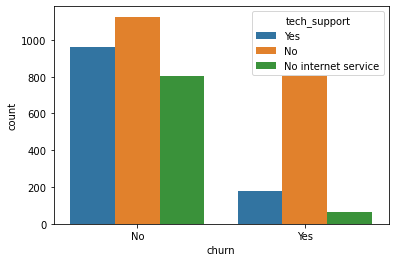

In [35]:
sns.countplot(data=train, x='churn', hue ='tech_support')

Customers without tech support are more likely to churn.

<AxesSubplot:xlabel='churn', ylabel='count'>

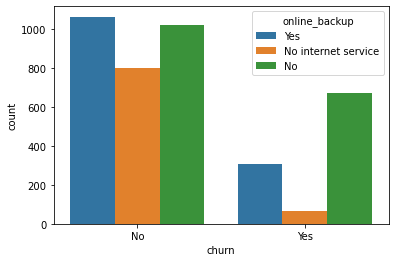

In [36]:
sns.countplot(data=train, x='churn', hue ='online_backup')

Customers without online backup are more likely to churn.

<AxesSubplot:xlabel='churn', ylabel='count'>

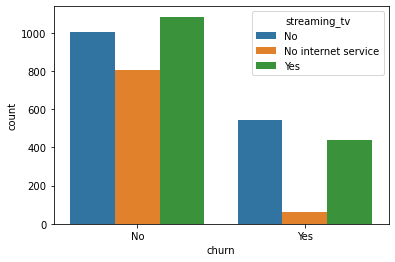

In [37]:
sns.countplot(data=train, x='churn', hue ='streaming_tv')

In [38]:
(train[train.churn == 'Yes'].streaming_tv == 'No').value_counts(normalize=True)

True     0.521033
False    0.478967
Name: streaming_tv, dtype: float64

Customers without streaming tv are more likely to churn.

<AxesSubplot:xlabel='churn', ylabel='count'>

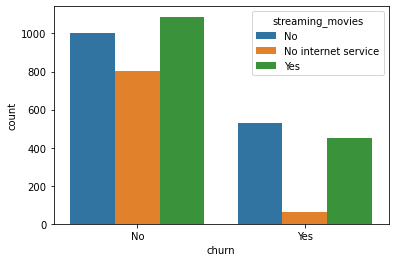

In [39]:
sns.countplot(data=train, x='churn', hue ='streaming_movies')

Customers without streaming movies are more likely to churn.

## Hypothesis Testing

### T -Test

<AxesSubplot:>

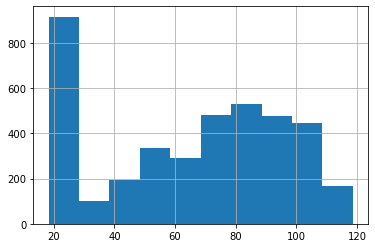

In [40]:
train.monthly_charges.hist()

<AxesSubplot:>

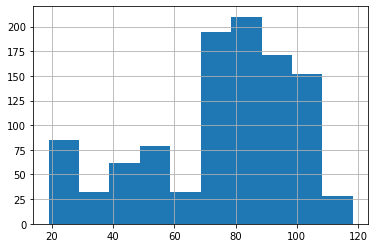

In [41]:
churned = train[train.churn == 'Yes'].monthly_charges

churned.hist()


Null hypothesis: The mean of monthly charges of churned customers <= the mean of monthly charges of all customers

Alternative hypothesis: The meean of monthly charges of churned customers > the mean of monthly charges of all customers

In [42]:
churned = train[train.churn == 'Yes'].monthly_charges
pop_mean = train.monthly_charges.mean()

t, p = stats.ttest_1samp(churned, pop_mean)

t,p


(13.037366230308015, 4.1597964256756695e-36)

In [43]:
if p/2 > alpha:
    print("Fail to reject the null")
elif t < 0:
    print("Fail to reject the null")
else:
    print("Reject the null")

Reject the null


Null hypothesis: The mean of the tenure of churned customers >= the mean of the tenure of all customers

Alternative hypothesis: The mean of the tenure of churned customers < the mean of the tenure of all customers

In [44]:
churned = train[train.churn == 'Yes'].tenure
pop_mean = train.tenure.mean()

t, p = stats.ttest_1samp(churned, pop_mean)

t,p


(-23.413234891011875, 8.47428580109463e-98)

In [45]:
if p/2 > alpha:
    print("Fail to reject the null")
elif t > 0:
    print("Fail to reject the null")
else:
    print("Reject the null")

Reject the null


### Chi- Squared

Null Hypothesis: Churn and being a senior citizen are independent.

Alternative Hypothesis: Churn and being a senior citizen are dependent.

In [46]:
observed = pd.crosstab(train.senior_citizen, train.churn)

In [47]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

1.7561315684822695e-23

In [48]:
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null")

Reject the null hypothesis


Null Hypothesis: Churn and having dependents are independent.

Alternative Hypothesis: Churn and having dependents are dependent.

In [49]:
observed = pd.crosstab(train.dependents, train.churn)
observed

churn,No,Yes
dependents,,
No,1885,860
Yes,1006,186


In [50]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

1.5385742575781703e-24

In [51]:
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null")

Reject the null hypothesis


Null Hypothesis: Churn and having a partner are independent.

Alternative Hypothesis: Churn and having a partner are dependent.

In [52]:
observed = pd.crosstab(train.partner, train.churn)
observed

churn,No,Yes
partner,,
No,1364,663
Yes,1527,383


In [53]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

3.578598859815084e-19

In [54]:
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null")

Reject the null hypothesis


Null Hypothesis: Churn and internet service type are independent.

Alternative Hypothesis: Churn and internet service type are dependent.

In [55]:
observed = pd.crosstab(train.internet_service_type, train.churn)

In [56]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

3.2062272759526154e-96

In [57]:
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null")

Reject the null hypothesis


Null Hypothesis: Churn and having fiber optic internet are independent.

Alternative Hypothesis: Churn and having fiber optic internet are dependent.

In [58]:
observed = pd.crosstab(train.internet_service_type == 'Fiber optic', train.churn)

In [59]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

2.831419548361709e-90

In [60]:
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null")

Reject the null hypothesis


Null hypothesis: Churn and payment type are independent.

Alternative hypothesis: Churn and payment type are dependent.

In [61]:
observed = pd.crosstab(train.payment_type, train.churn)
observed

churn,No,Yes
payment_type,,
Bank transfer (automatic),713,149
Credit card (automatic),750,145
Electronic check,708,581
Mailed check,720,171


In [62]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

4.64358817076333e-73

In [63]:
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null")

Reject the null hypothesis


Null hypothesis: Churn and electronic check payments are independent.

Alternative hypothesis: Churn and electronic check payments are dependent.

In [64]:
observed = pd.crosstab(train.payment_type == 'Electronic check', train.churn)
observed

churn,No,Yes
payment_type,,
False,2183,465
True,708,581


In [65]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

7.910587922260644e-75

In [66]:
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null")

Reject the null hypothesis


Null hypothesis: Churn and online security are independent.

Alternative hypothesis: Churn and online security are dependent.

In [67]:
observed = pd.crosstab(train.online_security, train.churn)
observed

churn,No,Yes
online_security,,
No,1099,819
No internet service,803,64
Yes,989,163


In [68]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

1.3862996282206897e-111

In [69]:
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null")

Reject the null hypothesis


Null hypothesis: Churn and online backup are independent.

Alternative hypothesis: Churn and online backup are dependent.

In [70]:
observed = pd.crosstab(train.online_backup, train.churn)
observed

churn,No,Yes
online_backup,,
No,1023,674
No internet service,803,64
Yes,1065,308


In [71]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

1.6093415124241013e-71

In [72]:
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null")

Reject the null hypothesis


Null hypothesis: Churn and tech support are independent.

Alternative hypothesis: Churn and tech support are dependent.

In [73]:
observed = pd.crosstab(train.tech_support, train.churn)
observed

churn,No,Yes
tech_support,,
No,1126,805
No internet service,803,64
Yes,962,177


In [74]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

8.373959266633126e-101

In [75]:
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null")

Reject the null hypothesis


### Takeaways

Key indicators for churn are:

        Family type:
            Seniors, those without partners, and those without dependents are more likely to churn.
            
        Monthly charges:
            Those with higher monthly charges are more likely to churn.
            
        Payment type:
            Those with electronic checks are more likely to churn.
            
        Internet type:
            Customers with fiber optic internet churn at a higher rate.
            
        Add-ons:
            Customers without tech support, online backup, or online security churn at higher rates.
        

## Modeling

True Positive: Predicted that a customer has churned and they did.

False Positive: Predicted that a customer has churned and they did not.

True Negative: Predicted that a customer had not churned and they did not.

False Negative: Predicted that a customer had not churned and they did.

In [76]:
# determine baseline accuracy
train.has_churned.value_counts(normalize=True)

0    0.734315
1    0.265685
Name: has_churned, dtype: float64

The baseline model is 73% accurate assuming that 0 customers churn.

### Decision Tree

- The best model optimized for accuracy has a max depth of 4 with a train accuracy of 80% and a validation accuracy of 78%	which out performs the baseline model. 


In [569]:
# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train.drop(columns=['customer_id', 'gender', 'partner', 'dependents',\
                              'phone_service', 'multiple_lines', 'online_security',\
                              'online_backup', 'device_protection', 'tech_support', 'streaming_tv',\
                              'streaming_movies', 'paperless_billing', 'churn', 'contract_type',\
                              'internet_service_type', 'payment_type', 'has_churned', 'is_female'])
y_train = train.has_churned

X_validate = validate.drop(columns=['customer_id', 'gender', 'partner', 'dependents',\
                              'phone_service', 'multiple_lines', 'online_security',\
                              'online_backup', 'device_protection', 'tech_support', 'streaming_tv',\
                              'streaming_movies', 'paperless_billing', 'churn', 'contract_type',\
                              'internet_service_type', 'payment_type', 'has_churned', 'is_female'])
y_validate = validate.has_churned

X_test = test.drop(columns=['customer_id', 'gender', 'partner', 'dependents',\
                              'phone_service', 'multiple_lines', 'online_security',\
                              'online_backup', 'device_protection', 'tech_support', 'streaming_tv',\
                              'streaming_movies', 'paperless_billing', 'churn', 'contract_type',\
                              'internet_service_type', 'payment_type', 'has_churned', 'is_female'])
y_test = test.has_churned

In [570]:
# create the decision tree
clf = DecisionTreeClassifier(max_depth=4, random_state=123)

In [571]:
# fit the model
clf = clf.fit(X_train, y_train)

[Text(362.7, 342.46799999999996, 'tenure <= 15.5\ngini = 0.39\nsamples = 3937\nvalue = [2891, 1046]\nclass = 0'),
 Text(181.35, 266.364, 'internet_service_type_Fiber optic <= 0.5\ngini = 0.498\nsamples = 1371\nvalue = [733, 638]\nclass = 0'),
 Text(90.675, 190.26, 'tenure <= 3.5\ngini = 0.416\nsamples = 804\nvalue = [567, 237]\nclass = 0'),
 Text(45.3375, 114.156, 'tech_support_No internet service <= 0.5\ngini = 0.491\nsamples = 356\nvalue = [202, 154]\nclass = 0'),
 Text(22.66875, 38.051999999999964, 'gini = 0.495\nsamples = 203\nvalue = [91, 112]\nclass = 1'),
 Text(68.00625, 38.051999999999964, 'gini = 0.398\nsamples = 153\nvalue = [111, 42]\nclass = 0'),
 Text(136.0125, 114.156, 'monthly_charges <= 20.925\ngini = 0.302\nsamples = 448\nvalue = [365, 83]\nclass = 0'),
 Text(113.34375, 38.051999999999964, 'gini = 0.111\nsamples = 152\nvalue = [143, 9]\nclass = 0'),
 Text(158.68125, 38.051999999999964, 'gini = 0.375\nsamples = 296\nvalue = [222, 74]\nclass = 0'),
 Text(272.025, 190.26,

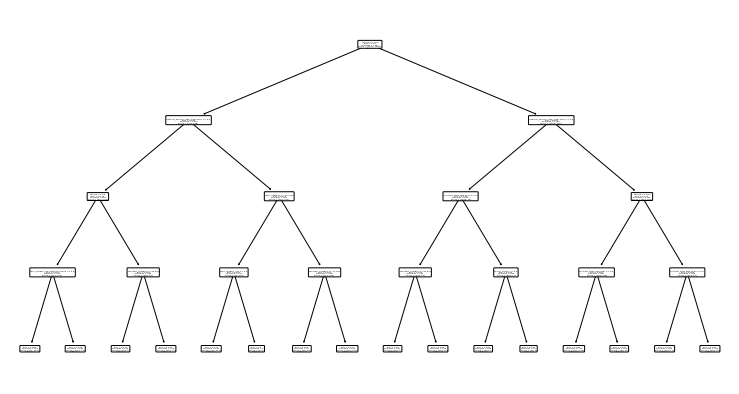

In [572]:
# visualize the decision tree
plt.figure(figsize=(13, 7))
plot_tree(clf, feature_names=X_train.columns, class_names = clf.classes_.astype(str), rounded=True)


In [573]:
# make prediction on train obeservations

y_pred1 = clf.predict(X_train)
y_pred1[0:5]


array([0, 0, 0, 0, 0])

In [574]:
y_pred_proba1 = clf.predict_proba(X_train)
y_pred_proba1[0:5]


array([[0.88990826, 0.11009174],
       [0.78078078, 0.21921922],
       [0.88990826, 0.11009174],
       [0.7254902 , 0.2745098 ],
       [0.88990826, 0.11009174]])

In [575]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.80


My deicision tree model beats baseline.

In [576]:
# confusion matrix

confusion_matrix(y_train, y_pred1)


array([[2676,  215],
       [ 570,  476]])

In [577]:
print(classification_report(y_train, y_pred1))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      2891
           1       0.69      0.46      0.55      1046

    accuracy                           0.80      3937
   macro avg       0.76      0.69      0.71      3937
weighted avg       0.79      0.80      0.79      3937



In [578]:
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))


Accuracy of Decision Tree classifier on validate set: 0.78


In [579]:
y_pred_val = clf.predict(X_validate)
print(classification_report(y_validate, y_pred_val))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1239
           1       0.61      0.44      0.51       449

    accuracy                           0.78      1688
   macro avg       0.72      0.67      0.68      1688
weighted avg       0.76      0.78      0.76      1688



In [580]:
for i in range(2, 21):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = tree.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

Tree with max depth of 2
                     0            1  accuracy    macro avg  weighted avg
precision     0.808605     0.707231  0.794006     0.757918      0.781672
recall        0.942580     0.383365  0.794006     0.662973      0.794006
f1-score      0.870468     0.497210  0.794006     0.683839      0.771299
support    2891.000000  1046.000000  0.794006  3937.000000   3937.000000

Tree with max depth of 3
                     0            1  accuracy    macro avg  weighted avg
precision     0.808605     0.707231  0.794006     0.757918      0.781672
recall        0.942580     0.383365  0.794006     0.662973      0.794006
f1-score      0.870468     0.497210  0.794006     0.683839      0.771299
support    2891.000000  1046.000000  0.794006  3937.000000   3937.000000

Tree with max depth of 4
                     0            1  accuracy    macro avg  weighted avg
precision     0.824399     0.688857   0.80061     0.756628      0.788388
recall        0.925631     0.455067   0.80061  

In [581]:
# Compare accuracy for in-sample and out-of-sample data
metrics = []

for i in range(2, 19):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = tree.score(X_train, y_train)
    
    out_of_sample_accuracy = tree.score(X_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,train_accuracy,validate_accuracy,difference
0,2,0.794006,0.776066,0.017939
1,3,0.794006,0.776066,0.017939
2,4,0.800610,0.777844,0.022766
3,5,0.806960,0.776066,0.030893
4,6,0.816866,0.778436,0.038430
5,7,0.831852,0.764810,0.067041
6,8,0.842774,0.762441,0.080333
7,9,0.859792,0.760071,0.099721
8,10,0.879350,0.753555,0.125795
9,11,0.896876,0.746445,0.150430


Accuracy of Decision Tree classifier on training set: 0.86


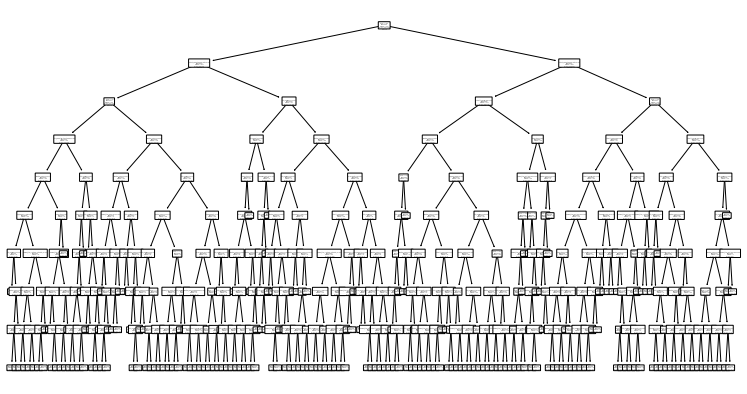

In [594]:
# create the decision tree
clf = DecisionTreeClassifier(max_depth=9, random_state=123)

# fit the model
clf = clf.fit(X_train, y_train)

# visualize the decision tree
plt.figure(figsize=(13, 7))
plot_tree(clf, feature_names=X_train.columns, class_names = clf.classes_.astype(str), rounded=True)


# make prediction on train obeservations

y_pred2 = clf.predict(X_train)
y_pred[0:5]


y_pred_proba2 = clf.predict_proba(X_train)
y_pred_proba[0:5]


print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))




In [597]:
print(classification_report(y_train, y_pred2))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2891
           1       0.75      0.70      0.73      1046

    accuracy                           0.86      3937
   macro avg       0.82      0.81      0.82      3937
weighted avg       0.86      0.86      0.86      3937



In [598]:
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))


Accuracy of Decision Tree classifier on validate set: 0.76


In [599]:
y_pred2=clf.predict(X_validate)

In [600]:
print(classification_report(y_validate, y_pred2))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1239
           1       0.55      0.55      0.55       449

    accuracy                           0.76      1688
   macro avg       0.69      0.69      0.69      1688
weighted avg       0.76      0.76      0.76      1688



### Random Forest

In [643]:
# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train.drop(columns=['customer_id', 'gender', 'partner', 'dependents',\
                              'phone_service', 'multiple_lines', 'online_security',\
                              'online_backup', 'device_protection', 'tech_support', 'streaming_tv',\
                              'streaming_movies', 'paperless_billing', 'churn', 'contract_type',\
                              'internet_service_type', 'payment_type', 'has_churned', 'is_female'])
y_train = train.has_churned

X_validate = validate.drop(columns=['customer_id', 'gender', 'partner', 'dependents',\
                              'phone_service', 'multiple_lines', 'online_security',\
                              'online_backup', 'device_protection', 'tech_support', 'streaming_tv',\
                              'streaming_movies', 'paperless_billing', 'churn', 'contract_type',\
                              'internet_service_type', 'payment_type', 'has_churned', 'is_female'])
y_validate = validate.has_churned

X_test = test.drop(columns=['customer_id', 'gender', 'partner', 'dependents',\
                              'phone_service', 'multiple_lines', 'online_security',\
                              'online_backup', 'device_protection', 'tech_support', 'streaming_tv',\
                              'streaming_movies', 'paperless_billing', 'churn', 'contract_type',\
                              'internet_service_type', 'payment_type', 'has_churned', 'is_female'])
y_test = test.has_churned

In [644]:
rf = RandomForestClassifier(max_depth=4, random_state=123)


In [645]:
rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=4, random_state=123)

In [646]:
print(rf.feature_importances_)


[0.00401548 0.21573429 0.05739278 0.15553208 0.00520697 0.00363917
 0.00037427 0.00883254 0.03295002 0.08605933 0.13520124 0.03227966
 0.00219958 0.08391422 0.00080804 0.00077615 0.00273981 0.01451199
 0.03718306 0.02532239 0.00574243 0.0231366  0.02231282 0.02244684
 0.00069119 0.01954819 0.00144885]


In [647]:
y_pred = rf.predict(X_train)
y_pred[0:5]

array([0, 0, 0, 0, 0])

In [648]:
y_pred_proba = rf.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.86879415, 0.13120585],
       [0.78783747, 0.21216253],
       [0.91445475, 0.08554525],
       [0.75520263, 0.24479737],
       [0.85799072, 0.14200928]])

In [649]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))


Accuracy of random forest classifier on training set: 0.80


In [650]:
print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.94      0.87      2891
           1       0.72      0.42      0.53      1046

    accuracy                           0.80      3937
   macro avg       0.77      0.68      0.70      3937
weighted avg       0.79      0.80      0.78      3937



In [651]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))


Accuracy of random forest classifier on test set: 0.79


In [652]:
y_pred = rf.predict(X_validate)

In [653]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1239
           1       0.66      0.41      0.50       449

    accuracy                           0.79      1688
   macro avg       0.73      0.66      0.68      1688
weighted avg       0.77      0.79      0.77      1688



In [623]:
metrics = []

for i in range(2, 19):
    # Make the model
    forest = RandomForestClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,train_accuracy,validate_accuracy,difference
0,2,0.764288,0.751185,0.013103
1,3,0.790704,0.771919,0.018784
2,4,0.802134,0.785545,0.016589
3,5,0.807214,0.787322,0.019891
4,6,0.813310,0.786730,0.026580
5,7,0.824994,0.795616,0.029378
6,8,0.840996,0.796801,0.044195
7,9,0.860808,0.789100,0.071708
8,10,0.886716,0.786137,0.100578
9,11,0.916942,0.786137,0.130804


### K- Nearest Neighbor

- The best KNN model is when k = 8	with a training accuracy of 81% and a validation accuracy of 78%. Recall rate on validation data for the positive case is 43%.

In [654]:
# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train.drop(columns=['customer_id', 'gender', 'partner', 'dependents',\
                              'phone_service', 'multiple_lines', 'online_security',\
                              'online_backup', 'device_protection', 'tech_support', 'streaming_tv',\
                              'streaming_movies', 'paperless_billing', 'churn', 'contract_type',\
                              'internet_service_type', 'payment_type', 'has_churned', 'is_female'])
y_train = train.has_churned

X_validate = validate.drop(columns=['customer_id', 'gender', 'partner', 'dependents',\
                              'phone_service', 'multiple_lines', 'online_security',\
                              'online_backup', 'device_protection', 'tech_support', 'streaming_tv',\
                              'streaming_movies', 'paperless_billing', 'churn', 'contract_type',\
                              'internet_service_type', 'payment_type', 'has_churned', 'is_female'])
y_validate = validate.has_churned

X_test = test.drop(columns=['customer_id', 'gender', 'partner', 'dependents',\
                              'phone_service', 'multiple_lines', 'online_security',\
                              'online_backup', 'device_protection', 'tech_support', 'streaming_tv',\
                              'streaming_movies', 'paperless_billing', 'churn', 'contract_type',\
                              'internet_service_type', 'payment_type', 'has_churned', 'is_female'])
y_test = test.has_churned

In [655]:
knn = KNeighborsClassifier(n_neighbors=15, weights='uniform')

In [656]:
knn.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=15)

In [657]:
y_pred = knn.predict(X_train)
y_pred[0:5]

array([0, 0, 0, 0, 0])

In [658]:
y_pred_proba = knn.predict_proba(X_train)
y_pred_proba[0:5]

array([[1.        , 0.        ],
       [0.93333333, 0.06666667],
       [1.        , 0.        ],
       [0.73333333, 0.26666667],
       [0.66666667, 0.33333333]])

In [659]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))


Accuracy of KNN classifier on training set: 0.80


In [660]:
print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.94      0.88      2891
           1       0.72      0.43      0.54      1046

    accuracy                           0.80      3937
   macro avg       0.77      0.68      0.71      3937
weighted avg       0.79      0.80      0.79      3937



In [661]:
print('Accuracy of KNN classifier on validate set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))


Accuracy of KNN classifier on validate set: 0.78


In [662]:
metrics = []

# loop through different values of k
for k in range(3, 21):
            
    # define the thing
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # fit the thing (remmeber only fit on training data)
    knn.fit(X_train, y_train)
    
    # use the thing (calculate accuracy)
    train_accuracy = knn.score(X_train, y_train)
    validate_accuracy = knn.score(X_validate, y_validate)
    
    output = {
        "k": k,
        "train_accuracy": train_accuracy,
        "validate_accuracy": validate_accuracy
    }
    
    metrics.append(output)

df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,k,train_accuracy,validate_accuracy,difference
0,3,0.858522,0.740521,0.118000
1,4,0.832868,0.765995,0.066872
2,5,0.830582,0.755924,0.074657
3,6,0.818898,0.772512,0.046386
4,7,0.819406,0.776066,0.043339
5,8,0.812802,0.783768,0.029034
6,9,0.815342,0.777844,0.037498
7,10,0.809246,0.770142,0.039103
8,11,0.811786,0.769550,0.042236
9,12,0.805944,0.773697,0.032247


In [663]:
y_pred = knn.predict(X_validate)

In [664]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.92      0.86      1239
           1       0.63      0.35      0.45       449

    accuracy                           0.77      1688
   macro avg       0.71      0.64      0.65      1688
weighted avg       0.75      0.77      0.75      1688



### Logistic Regression - Model 1

- The logistic regression model has a training accuracy of 76% with a validation accuracy of 73%.

In [665]:
# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train.drop(columns=['customer_id', 'gender', 'partner', 'dependents',\
                              'phone_service', 'multiple_lines', 'online_security',\
                              'online_backup', 'device_protection', 'tech_support', 'streaming_tv',\
                              'streaming_movies', 'paperless_billing', 'churn', 'contract_type',\
                              'internet_service_type', 'payment_type', 'has_churned', 'is_female'])
y_train = train.has_churned

X_validate = validate.drop(columns=['customer_id', 'gender', 'partner', 'dependents',\
                              'phone_service', 'multiple_lines', 'online_security',\
                              'online_backup', 'device_protection', 'tech_support', 'streaming_tv',\
                              'streaming_movies', 'paperless_billing', 'churn', 'contract_type',\
                              'internet_service_type', 'payment_type', 'has_churned', 'is_female'])
y_validate = validate.has_churned

X_test = test.drop(columns=['customer_id', 'gender', 'partner', 'dependents',\
                              'phone_service', 'multiple_lines', 'online_security',\
                              'online_backup', 'device_protection', 'tech_support', 'streaming_tv',\
                              'streaming_movies', 'paperless_billing', 'churn', 'contract_type',\
                              'internet_service_type', 'payment_type', 'has_churned', 'is_female'])
y_test = test.has_churned

In [666]:
# from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(C=1, class_weight='balanced', random_state=123, intercept_scaling=1, solver='lbfgs')



In [667]:
logit.fit(X_train, y_train)


LogisticRegression(C=1, class_weight='balanced', random_state=123)

In [668]:
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)


Coefficient: 
 [[ 3.78306146e-01 -6.04729196e-02  1.57409818e-02  3.09587773e-04
   4.35568425e-02 -9.75638717e-02 -3.78006492e-01  3.59774680e-01
  -5.46558693e-01 -8.22355572e-01  4.70847535e-01 -9.87340090e-02
   7.24823359e-03  2.36444192e-01 -2.08728713e-02  5.41467472e-01
   1.81832880e-01 -9.87340090e-02 -5.99098353e-01 -9.87340090e-02
  -1.59138557e-01 -9.87340090e-02 -5.03986921e-01 -9.87340090e-02
  -1.48817538e-01 -9.87340090e-02 -8.33544817e-02]]
Intercept: 
 [0.16298496]


In [669]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))


Accuracy of Logistic Regression classifier on training set: 0.76


In [670]:
y_pred = logit.predict(X_train)
y_pred[0:5]

array([0, 0, 0, 0, 0])

In [671]:
y_pred_proba = logit.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.92636951, 0.07363049],
       [0.84286465, 0.15713535],
       [0.82074103, 0.17925897],
       [0.65353346, 0.34646654],
       [0.8234333 , 0.1765667 ]])

In [672]:
print('Accuracy of Logistic Regression classifier on validate set: {:.2f}'
     .format(logit.score(X_validate, y_validate)))



Accuracy of Logistic Regression classifier on validate set: 0.73


In [431]:
print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.74      0.82      2891
           1       0.53      0.79      0.63      1046

    accuracy                           0.76      3937
   macro avg       0.72      0.77      0.73      3937
weighted avg       0.81      0.76      0.77      3937



In [432]:
y_pred = logit.predict(X_validate)

print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1239
           1       0.50      0.80      0.62       449

    accuracy                           0.73      1688
   macro avg       0.70      0.75      0.71      1688
weighted avg       0.80      0.73      0.75      1688



### Best fit model - Logistic Regression Model 1 - Accuracy on test data
- This model had an 80% accuracy on train data, 73% on validation data (just above baseline). However, the model had the highest recall rate on the posiive case. The most costly event would be a false negative, predicting a customer did not churn, when in fact, they did churn. While other models would be more accurate, this model was chosen specifically for its optimization for reducing false negatives.

In [674]:
print('Accuracy of Logistic Regression classifier on test set: {:.2f}'
     .format(logit.score(X_test, y_test)))


Accuracy of Logistic Regression classifier on test set: 0.75


### Logistic Regression - Model 2

In [557]:
logit2 = LogisticRegression(C=.01, class_weight='balanced', random_state=123, solver='lbfgs')


In [558]:
logit2.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight='balanced', random_state=123)

In [559]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit2.score(X_train, y_train)))


Accuracy of Logistic Regression classifier on training set: 0.75


In [560]:
print('Accuracy of Logistic Regression classifier on validateset: {:.2f}'
     .format(logit2.score(X_validate, y_validate)))

Accuracy of Logistic Regression classifier on validateset: 0.73


In [453]:
y_pred = logit2.predict(X_validate)

print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1239
           1       0.50      0.78      0.61       449

    accuracy                           0.73      1688
   macro avg       0.70      0.75      0.70      1688
weighted avg       0.79      0.73      0.75      1688



### Logistic Regression - Model 3

In [457]:
features = ['tenure', 'senior_citizen', 'has_partner', 'has_dependents', 'monthly_charges', 'online_security_Yes',\
            'online_backup_Yes', 'tech_support_Yes', 'payment_type_Electronic check']

In [458]:
# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train[features]
y_train = train.has_churned

X_validate = validate[features]
y_validate = validate.has_churned

X_test = test[features]
y_test = test.has_churned

In [459]:
logit3 = LogisticRegression(C=1, class_weight='balanced', random_state=123, solver='lbfgs')


In [460]:
logit3.fit(X_train, y_train)

LogisticRegression(C=1, class_weight='balanced', random_state=123)

In [315]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))


ValueError: X has 9 features per sample; expecting 27